In [399]:
from ott.solvers import linear
from ott.geometry import pointcloud
import jax.numpy as jnp
import jax
from jaxtyping import Array, Float
from ott.solvers.linear.implicit_differentiation import ImplicitDiff
import matplotlib.pyplot as plt
import optax
import functools

<BarContainer object of 201 artists>

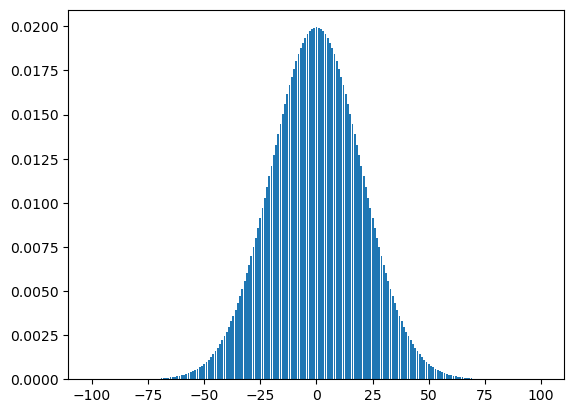

In [431]:
# initialize a gaussian kernel, mu_true, on domain X
size = 100
sigma = 20
X = jnp.arange(-size, size + 1, 1).astype(float)
mu_true = jnp.exp(-((X)**2) / (2 * sigma**2)) # gaussian kernel (sigma = 1, center = 0)
mu_true /= jnp.sum(mu_true)
plt.bar(X, mu_true)

In [432]:
solve_fn = jax.jit(linear.solve)

"""
Compute regularized ot cost for transporting between marginals mu and mu_true on geometry x
"""
def ot_marginal_loss(mu: Float[Array, "n "], mu_true: Float[Array, "n "], x: Float[Array, "n d"]):
    geom = pointcloud.PointCloud(x, x)
    ot = solve_fn(geom, implicit_diff=ImplicitDiff(), a=mu, b=mu_true)
    return ot.reg_ot_cost

"""
1-d gaussian kernel with center c, standard deviation sigma, domain
"""
def gaussian_kernel(c, sigma, X):
    mu = jnp.exp(-((X-c)**2)/(2 * sigma**2))
    mu /= jnp.sum(mu)
    return mu

"""
learning the center of a gaussian marginal - doesn't work
"""
def loss(c: Array, mu_true: Float[Array, "n "], sigma: Float=5.0, X: Float[Array, "n "] = X):
    # chatgpt-generated code
    log_mu = -((X - c) ** 2) / (2 * sigma ** 2)  # Log-space Gaussian kernel
    mu = jnp.exp(log_mu - jnp.logsumexp(log_mu))  # More numerically stable normalization
    
    return jnp.mean(mu)
    #return ot_marginal_loss(mu, mu_true, X.reshape(X.shape[0], 1).astype(float)) # return cost to transport to mu_true

"""
loss function for logits of a probability distribution
"""
def logit_loss(theta: Float[Array, "n"], mu_true: Float[Array, "n "], X: Float[Array, "n 1 "] = X):
    mu = jax.nn.softmax(theta)
    return ot_marginal_loss(mu, mu_true, X)

In [449]:
"""
l2 distance between logits and probability distribution
"""
def logit_l2_loss(theta: Float[Array, "n "], marginal: Float[Array, "n "]):
    mu = jax.nn.softmax(theta)
    return jnp.sqrt(jnp.sum((mu - marginal)**2))

"""
learn the logits of a probability distribution
"""
def learn_marginal_logits(marginal: Float[Array, "n "], X: Float[Array, "n "], seed=42, learn_with_w2=False):
    solver = optax.adam(learning_rate=0.03)
    key = jax.random.PRNGKey(42)
    key, subkey = jax.random.split(key)
    
    theta = jax.random.normal(key=subkey, shape=X.shape[0])
    opt_state = solver.init(theta)
    
    X_reshaped = X.reshape((X.shape[0], 1)).astype(float)
    
    if learn_with_w2: # learn using 2-wasserstein distance
        loss_fn = functools.partial(logit_loss, mu_true=marginal, X=X_reshaped) # make logit loss a function of theta
    else:
        loss_fn = functools.partial(logit_l2_loss, marginal=marginal)
    
    @jax.jit
    def make_step(theta, opt_state):
        loss_val, grads = jax.value_and_grad(loss_fn)(theta)
        updates, opt_state = solver.update(grads, opt_state)
        theta = optax.apply_updates(theta, updates)
        return loss_val, theta, opt_state
    
    for i in range(5000):
        loss_val, theta, opt_state = make_step(theta, opt_state) # gradient update based on W2 distance
        l2_loss_val = logit_l2_loss(theta, marginal)
        print(f"iteration {i}, loss value {loss_val}, l2 loss: {l2_loss_val}")
    
    return theta

In [450]:
# initialize a random array
learned = learn_marginal_logits(mu_true, X, learn_with_w2=True)

iteration 0, loss value 2000.349609375, l2 loss: 0.12075093388557434
iteration 1, loss value 1946.9454345703125, l2 loss: 0.11954902112483978
iteration 2, loss value 1894.2677001953125, l2 loss: 0.11841891705989838
iteration 3, loss value 1842.3936767578125, l2 loss: 0.11735985428094864
iteration 4, loss value 1791.4071044921875, l2 loss: 0.1163673847913742
iteration 5, loss value 1741.388916015625, l2 loss: 0.11543344706296921
iteration 6, loss value 1692.4056396484375, l2 loss: 0.11454766243696213
iteration 7, loss value 1644.509033203125, l2 loss: 0.11370165646076202
iteration 8, loss value 1597.7357177734375, l2 loss: 0.11289335787296295
iteration 9, loss value 1552.1171875, l2 loss: 0.11212658882141113
iteration 10, loss value 1507.6837158203125, l2 loss: 0.11140749603509903
iteration 11, loss value 1464.4664306640625, l2 loss: 0.11074153333902359
iteration 12, loss value 1422.4932861328125, l2 loss: 0.11013220250606537
iteration 13, loss value 1381.78955078125, l2 loss: 0.1095810

iteration 124, loss value 385.498779296875, l2 loss: 0.1059250459074974
iteration 125, loss value 384.5989990234375, l2 loss: 0.10583799332380295
iteration 126, loss value 383.7192687988281, l2 loss: 0.10575400292873383
iteration 127, loss value 382.86004638671875, l2 loss: 0.10567308962345123
iteration 128, loss value 382.0199279785156, l2 loss: 0.10559529066085815
iteration 129, loss value 381.1991271972656, l2 loss: 0.1055205911397934
iteration 130, loss value 380.3960876464844, l2 loss: 0.10544902086257935
iteration 131, loss value 379.6112976074219, l2 loss: 0.10538060963153839
iteration 132, loss value 378.8444519042969, l2 loss: 0.10531537979841232
iteration 133, loss value 378.0948791503906, l2 loss: 0.10525327920913696
iteration 134, loss value 377.36138916015625, l2 loss: 0.1051943302154541
iteration 135, loss value 376.64453125, l2 loss: 0.10513855516910553
iteration 136, loss value 375.94366455078125, l2 loss: 0.10508589446544647
iteration 137, loss value 375.2581481933594,

iteration 246, loss value 346.93646240234375, l2 loss: 0.11022739857435226
iteration 247, loss value 346.8678894042969, l2 loss: 0.11030140519142151
iteration 248, loss value 346.80169677734375, l2 loss: 0.11037492752075195
iteration 249, loss value 346.73583984375, l2 loss: 0.11044799536466599
iteration 250, loss value 346.6713562011719, l2 loss: 0.1105206087231636
iteration 251, loss value 346.6081237792969, l2 loss: 0.11059275269508362
iteration 252, loss value 346.54638671875, l2 loss: 0.11066437512636185
iteration 253, loss value 346.4851989746094, l2 loss: 0.11073553562164307
iteration 254, loss value 346.4257507324219, l2 loss: 0.11080612987279892
iteration 255, loss value 346.3666687011719, l2 loss: 0.11087625473737717
iteration 256, loss value 346.30902099609375, l2 loss: 0.11094580590724945
iteration 257, loss value 346.2525634765625, l2 loss: 0.11101483553647995
iteration 258, loss value 346.1969909667969, l2 loss: 0.11108329147100449
iteration 259, loss value 346.1424255371

iteration 370, loss value 343.1457214355469, l2 loss: 0.1147804707288742
iteration 371, loss value 343.1309814453125, l2 loss: 0.11478397995233536
iteration 372, loss value 343.11651611328125, l2 loss: 0.11478712409734726
iteration 373, loss value 343.1015319824219, l2 loss: 0.11478996276855469
iteration 374, loss value 343.0870056152344, l2 loss: 0.11479248851537704
iteration 375, loss value 343.0729675292969, l2 loss: 0.11479468643665314
iteration 376, loss value 343.0587158203125, l2 loss: 0.11479657888412476
iteration 377, loss value 343.0447998046875, l2 loss: 0.1147981509566307
iteration 378, loss value 343.0307312011719, l2 loss: 0.11479941755533218
iteration 379, loss value 343.01654052734375, l2 loss: 0.11480037868022919
iteration 380, loss value 343.00250244140625, l2 loss: 0.11480103433132172
iteration 381, loss value 342.9883728027344, l2 loss: 0.11480142176151276
iteration 382, loss value 342.97442626953125, l2 loss: 0.11480154097080231
iteration 383, loss value 342.961120

iteration 486, loss value 341.80938720703125, l2 loss: 0.11399037390947342
iteration 487, loss value 341.80023193359375, l2 loss: 0.11397980898618698
iteration 488, loss value 341.7913818359375, l2 loss: 0.11396925151348114
iteration 489, loss value 341.7815856933594, l2 loss: 0.11395873129367828
iteration 490, loss value 341.77264404296875, l2 loss: 0.11394823342561722
iteration 491, loss value 341.7635498046875, l2 loss: 0.11393772065639496
iteration 492, loss value 341.7544860839844, l2 loss: 0.11392723023891449
iteration 493, loss value 341.7452087402344, l2 loss: 0.1139167994260788
iteration 494, loss value 341.736328125, l2 loss: 0.1139063611626625
iteration 495, loss value 341.7273864746094, l2 loss: 0.11389593034982681
iteration 496, loss value 341.71832275390625, l2 loss: 0.11388552188873291
iteration 497, loss value 341.7095642089844, l2 loss: 0.11387515813112259
iteration 498, loss value 341.7004089355469, l2 loss: 0.11386478692293167
iteration 499, loss value 341.6915283203

iteration 610, loss value 340.8643493652344, l2 loss: 0.11294375360012054
iteration 611, loss value 340.85791015625, l2 loss: 0.11293796449899673
iteration 612, loss value 340.85186767578125, l2 loss: 0.11293214559555054
iteration 613, loss value 340.8454284667969, l2 loss: 0.11292639374732971
iteration 614, loss value 340.8392333984375, l2 loss: 0.11292070895433426
iteration 615, loss value 340.83319091796875, l2 loss: 0.11291506141424179
iteration 616, loss value 340.82733154296875, l2 loss: 0.1129094585776329
iteration 617, loss value 340.8211669921875, l2 loss: 0.11290384083986282
iteration 618, loss value 340.8149108886719, l2 loss: 0.11289830505847931
iteration 619, loss value 340.8089294433594, l2 loss: 0.11289280652999878
iteration 620, loss value 340.80303955078125, l2 loss: 0.11288730055093765
iteration 621, loss value 340.7967224121094, l2 loss: 0.11288188397884369
iteration 622, loss value 340.7908630371094, l2 loss: 0.11287649720907211
iteration 623, loss value 340.7850952

iteration 729, loss value 340.2516784667969, l2 loss: 0.1124722957611084
iteration 730, loss value 340.2474060058594, l2 loss: 0.11246970295906067
iteration 731, loss value 340.2431640625, l2 loss: 0.11246711760759354
iteration 732, loss value 340.2389831542969, l2 loss: 0.1124645471572876
iteration 733, loss value 340.23480224609375, l2 loss: 0.11246203631162643
iteration 734, loss value 340.2305603027344, l2 loss: 0.1124594584107399
iteration 735, loss value 340.2263488769531, l2 loss: 0.11245694756507874
iteration 736, loss value 340.22247314453125, l2 loss: 0.11245445907115936
iteration 737, loss value 340.2184753417969, l2 loss: 0.1124519556760788
iteration 738, loss value 340.2137756347656, l2 loss: 0.11244946718215942
iteration 739, loss value 340.2098083496094, l2 loss: 0.11244699358940125
iteration 740, loss value 340.2056579589844, l2 loss: 0.11244450509548187
iteration 741, loss value 340.20123291015625, l2 loss: 0.11244210600852966
iteration 742, loss value 340.197723388671

iteration 864, loss value 339.78143310546875, l2 loss: 0.11218827217817307
iteration 865, loss value 339.77911376953125, l2 loss: 0.11218623071908951
iteration 866, loss value 339.77557373046875, l2 loss: 0.11218422651290894
iteration 867, loss value 339.77276611328125, l2 loss: 0.11218216270208359
iteration 868, loss value 339.76995849609375, l2 loss: 0.11218015849590302
iteration 869, loss value 339.76739501953125, l2 loss: 0.11217813938856125
iteration 870, loss value 339.7646179199219, l2 loss: 0.1121760681271553
iteration 871, loss value 339.761474609375, l2 loss: 0.11217404901981354
iteration 872, loss value 339.7591552734375, l2 loss: 0.11217201501131058
iteration 873, loss value 339.7562561035156, l2 loss: 0.11216994374990463
iteration 874, loss value 339.753173828125, l2 loss: 0.11216792464256287
iteration 875, loss value 339.7503967285156, l2 loss: 0.11216584593057632
iteration 876, loss value 339.7478942871094, l2 loss: 0.11216380447149277
iteration 877, loss value 339.74530

iteration 988, loss value 339.4822082519531, l2 loss: 0.1118912473320961
iteration 989, loss value 339.4799499511719, l2 loss: 0.11188837140798569
iteration 990, loss value 339.47845458984375, l2 loss: 0.1118854284286499
iteration 991, loss value 339.4759826660156, l2 loss: 0.1118825227022171
iteration 992, loss value 339.4739990234375, l2 loss: 0.11187957972288132
iteration 993, loss value 339.4722595214844, l2 loss: 0.11187667399644852
iteration 994, loss value 339.47015380859375, l2 loss: 0.11187368631362915
iteration 995, loss value 339.4676513671875, l2 loss: 0.11187072098255157
iteration 996, loss value 339.4657897949219, l2 loss: 0.1118677631020546
iteration 997, loss value 339.464111328125, l2 loss: 0.11186479032039642
iteration 998, loss value 339.4620056152344, l2 loss: 0.11186179518699646
iteration 999, loss value 339.46002197265625, l2 loss: 0.1118588000535965
iteration 1000, loss value 339.4579772949219, l2 loss: 0.11185579746961594
iteration 1001, loss value 339.456115722

iteration 1112, loss value 339.26251220703125, l2 loss: 0.11145651340484619
iteration 1113, loss value 339.2606506347656, l2 loss: 0.11145241558551788
iteration 1114, loss value 339.2594909667969, l2 loss: 0.11144828051328659
iteration 1115, loss value 339.2578125, l2 loss: 0.1114441528916359
iteration 1116, loss value 339.2563171386719, l2 loss: 0.11144000291824341
iteration 1117, loss value 339.2547302246094, l2 loss: 0.11143582314252853
iteration 1118, loss value 339.2532043457031, l2 loss: 0.11143167316913605
iteration 1119, loss value 339.2518005371094, l2 loss: 0.11142749339342117
iteration 1120, loss value 339.25018310546875, l2 loss: 0.1114233061671257
iteration 1121, loss value 339.2484130859375, l2 loss: 0.11141911894083023
iteration 1122, loss value 339.2471923828125, l2 loss: 0.11141493171453476
iteration 1123, loss value 339.2455749511719, l2 loss: 0.1114107072353363
iteration 1124, loss value 339.2439270019531, l2 loss: 0.11140648275613785
iteration 1125, loss value 339.2

iteration 1236, loss value 339.0935363769531, l2 loss: 0.11088134348392487
iteration 1237, loss value 339.0926208496094, l2 loss: 0.11087623983621597
iteration 1238, loss value 339.09161376953125, l2 loss: 0.11087113618850708
iteration 1239, loss value 339.09039306640625, l2 loss: 0.11086602509021759
iteration 1240, loss value 339.08935546875, l2 loss: 0.1108609065413475
iteration 1241, loss value 339.087890625, l2 loss: 0.11085575819015503
iteration 1242, loss value 339.08648681640625, l2 loss: 0.11085066944360733
iteration 1243, loss value 339.08575439453125, l2 loss: 0.11084552109241486
iteration 1244, loss value 339.08416748046875, l2 loss: 0.11084038764238358
iteration 1245, loss value 339.08306884765625, l2 loss: 0.1108352318406105
iteration 1246, loss value 339.0819396972656, l2 loss: 0.11083007603883743
iteration 1247, loss value 339.08026123046875, l2 loss: 0.11082492768764496
iteration 1248, loss value 339.0794677734375, l2 loss: 0.1108197346329689
iteration 1249, loss value 

iteration 1360, loss value 338.9590759277344, l2 loss: 0.1102144792675972
iteration 1361, loss value 338.95794677734375, l2 loss: 0.11020892858505249
iteration 1362, loss value 338.9576110839844, l2 loss: 0.11020335555076599
iteration 1363, loss value 338.9557189941406, l2 loss: 0.11019778251647949
iteration 1364, loss value 338.9549865722656, l2 loss: 0.11019222438335419
iteration 1365, loss value 338.9537353515625, l2 loss: 0.11018666625022888
iteration 1366, loss value 338.95355224609375, l2 loss: 0.11018108576536179
iteration 1367, loss value 338.95196533203125, l2 loss: 0.11017552763223648
iteration 1368, loss value 338.9510192871094, l2 loss: 0.11016996949911118
iteration 1369, loss value 338.95025634765625, l2 loss: 0.11016438901424408
iteration 1370, loss value 338.94915771484375, l2 loss: 0.11015880852937698
iteration 1371, loss value 338.9480895996094, l2 loss: 0.11015326529741287
iteration 1372, loss value 338.9473571777344, l2 loss: 0.11014767736196518
iteration 1373, loss 

iteration 1484, loss value 338.8468933105469, l2 loss: 0.10952860862016678
iteration 1485, loss value 338.84588623046875, l2 loss: 0.10952318459749222
iteration 1486, loss value 338.8447570800781, l2 loss: 0.10951782017946243
iteration 1487, loss value 338.84454345703125, l2 loss: 0.10951242595911026
iteration 1488, loss value 338.8436584472656, l2 loss: 0.10950704663991928
iteration 1489, loss value 338.8429260253906, l2 loss: 0.1095016747713089
iteration 1490, loss value 338.8416748046875, l2 loss: 0.10949628055095673
iteration 1491, loss value 338.8409118652344, l2 loss: 0.10949092358350754
iteration 1492, loss value 338.8404235839844, l2 loss: 0.10948555171489716
iteration 1493, loss value 338.8392028808594, l2 loss: 0.10948017239570618
iteration 1494, loss value 338.8387451171875, l2 loss: 0.10947481542825699
iteration 1495, loss value 338.837890625, l2 loss: 0.10946948826313019
iteration 1496, loss value 338.83746337890625, l2 loss: 0.1094641163945198
iteration 1497, loss value 3

iteration 1608, loss value 338.75128173828125, l2 loss: 0.10890070348978043
iteration 1609, loss value 338.7505798339844, l2 loss: 0.10889606922864914
iteration 1610, loss value 338.74993896484375, l2 loss: 0.10889145731925964
iteration 1611, loss value 338.7496032714844, l2 loss: 0.10888682305812836
iteration 1612, loss value 338.74847412109375, l2 loss: 0.10888223350048065
iteration 1613, loss value 338.7480163574219, l2 loss: 0.10887762159109116
iteration 1614, loss value 338.7472839355469, l2 loss: 0.10887302458286285
iteration 1615, loss value 338.74652099609375, l2 loss: 0.10886844992637634
iteration 1616, loss value 338.7455139160156, l2 loss: 0.10886386781930923
iteration 1617, loss value 338.7448425292969, l2 loss: 0.10885933041572571
iteration 1618, loss value 338.7445983886719, l2 loss: 0.10885477066040039
iteration 1619, loss value 338.74383544921875, l2 loss: 0.10885024070739746
iteration 1620, loss value 338.7431335449219, l2 loss: 0.10884569585323334
iteration 1621, loss

iteration 1732, loss value 338.6686706542969, l2 loss: 0.10839907079935074
iteration 1733, loss value 338.66778564453125, l2 loss: 0.10839569568634033
iteration 1734, loss value 338.66693115234375, l2 loss: 0.10839234292507172
iteration 1735, loss value 338.66680908203125, l2 loss: 0.10838896036148071
iteration 1736, loss value 338.6653747558594, l2 loss: 0.1083856150507927
iteration 1737, loss value 338.6653747558594, l2 loss: 0.10838228464126587
iteration 1738, loss value 338.6647644042969, l2 loss: 0.10837893933057785
iteration 1739, loss value 338.6636047363281, l2 loss: 0.10837563872337341
iteration 1740, loss value 338.6634521484375, l2 loss: 0.10837232321500778
iteration 1741, loss value 338.6628112792969, l2 loss: 0.10836905241012573
iteration 1742, loss value 338.6620788574219, l2 loss: 0.10836575925350189
iteration 1743, loss value 338.6614074707031, l2 loss: 0.10836251080036163
iteration 1744, loss value 338.660888671875, l2 loss: 0.10835926234722137
iteration 1745, loss val

iteration 1855, loss value 338.5963134765625, l2 loss: 0.10807497799396515
iteration 1856, loss value 338.59564208984375, l2 loss: 0.10807310044765472
iteration 1857, loss value 338.5949401855469, l2 loss: 0.10807127505540848
iteration 1858, loss value 338.5942077636719, l2 loss: 0.10806948691606522
iteration 1859, loss value 338.5936279296875, l2 loss: 0.10806766152381897
iteration 1860, loss value 338.5931091308594, l2 loss: 0.1080658808350563
iteration 1861, loss value 338.59283447265625, l2 loss: 0.10806410014629364
iteration 1862, loss value 338.5921325683594, l2 loss: 0.10806232690811157
iteration 1863, loss value 338.591064453125, l2 loss: 0.10806059092283249
iteration 1864, loss value 338.5911865234375, l2 loss: 0.1080588772892952
iteration 1865, loss value 338.5910339355469, l2 loss: 0.10805714130401611
iteration 1866, loss value 338.5899353027344, l2 loss: 0.10805542021989822
iteration 1867, loss value 338.58935546875, l2 loss: 0.10805370658636093
iteration 1868, loss value 3

iteration 1979, loss value 338.531494140625, l2 loss: 0.10794917494058609
iteration 1980, loss value 338.5312805175781, l2 loss: 0.10794901102781296
iteration 1981, loss value 338.5301818847656, l2 loss: 0.10794885456562042
iteration 1982, loss value 338.5299987792969, l2 loss: 0.10794870555400848
iteration 1983, loss value 338.5295715332031, l2 loss: 0.10794857889413834
iteration 1984, loss value 338.5289001464844, l2 loss: 0.10794846713542938
iteration 1985, loss value 338.52838134765625, l2 loss: 0.10794835537672043
iteration 1986, loss value 338.52789306640625, l2 loss: 0.10794827342033386
iteration 1987, loss value 338.5279541015625, l2 loss: 0.10794820636510849
iteration 1988, loss value 338.52764892578125, l2 loss: 0.10794810950756073
iteration 1989, loss value 338.52655029296875, l2 loss: 0.10794807225465775
iteration 1990, loss value 338.5263671875, l2 loss: 0.10794802755117416
iteration 1991, loss value 338.525634765625, l2 loss: 0.10794798284769058
iteration 1992, loss value

iteration 2103, loss value 338.4750061035156, l2 loss: 0.10802754759788513
iteration 2104, loss value 338.47418212890625, l2 loss: 0.10802894830703735
iteration 2105, loss value 338.47369384765625, l2 loss: 0.10803040117025375
iteration 2106, loss value 338.4733581542969, l2 loss: 0.10803184658288956
iteration 2107, loss value 338.47283935546875, l2 loss: 0.10803333669900894
iteration 2108, loss value 338.4728698730469, l2 loss: 0.10803476721048355
iteration 2109, loss value 338.4718322753906, l2 loss: 0.10803626477718353
iteration 2110, loss value 338.4716491699219, l2 loss: 0.10803775489330292
iteration 2111, loss value 338.4711608886719, l2 loss: 0.10803928971290588
iteration 2112, loss value 338.47088623046875, l2 loss: 0.10804082453250885
iteration 2113, loss value 338.470703125, l2 loss: 0.10804234445095062
iteration 2114, loss value 338.4701843261719, l2 loss: 0.10804390162229538
iteration 2115, loss value 338.4700927734375, l2 loss: 0.10804544389247894
iteration 2116, loss valu

iteration 2220, loss value 338.4275207519531, l2 loss: 0.1082727387547493
iteration 2221, loss value 338.4269714355469, l2 loss: 0.10827551037073135
iteration 2222, loss value 338.427490234375, l2 loss: 0.10827821493148804
iteration 2223, loss value 338.4267883300781, l2 loss: 0.10828098654747009
iteration 2224, loss value 338.4263000488281, l2 loss: 0.10828373581171036
iteration 2225, loss value 338.4257507324219, l2 loss: 0.10828652232885361
iteration 2226, loss value 338.4253234863281, l2 loss: 0.10828932374715805
iteration 2227, loss value 338.4249572753906, l2 loss: 0.1082921251654625
iteration 2228, loss value 338.4248962402344, l2 loss: 0.10829492658376694
iteration 2229, loss value 338.4244079589844, l2 loss: 0.10829775780439377
iteration 2230, loss value 338.4239501953125, l2 loss: 0.1083005890250206
iteration 2231, loss value 338.4238586425781, l2 loss: 0.10830342769622803
iteration 2232, loss value 338.42333984375, l2 loss: 0.10830625891685486
iteration 2233, loss value 338.

iteration 2344, loss value 338.3833923339844, l2 loss: 0.10868317633867264
iteration 2345, loss value 338.38385009765625, l2 loss: 0.10868700593709946
iteration 2346, loss value 338.383544921875, l2 loss: 0.10869084298610687
iteration 2347, loss value 338.3827819824219, l2 loss: 0.10869469493627548
iteration 2348, loss value 338.38262939453125, l2 loss: 0.10869856923818588
iteration 2349, loss value 338.3826599121094, l2 loss: 0.1087024137377739
iteration 2350, loss value 338.3819580078125, l2 loss: 0.1087062805891037
iteration 2351, loss value 338.3816833496094, l2 loss: 0.10871016979217529
iteration 2352, loss value 338.3815612792969, l2 loss: 0.10871405154466629
iteration 2353, loss value 338.38092041015625, l2 loss: 0.10871795564889908
iteration 2354, loss value 338.381103515625, l2 loss: 0.10872185975313187
iteration 2355, loss value 338.38079833984375, l2 loss: 0.10872578620910645
iteration 2356, loss value 338.38067626953125, l2 loss: 0.10872966051101685
iteration 2357, loss val

iteration 2467, loss value 338.3468017578125, l2 loss: 0.1092042624950409
iteration 2468, loss value 338.3463439941406, l2 loss: 0.1092088371515274
iteration 2469, loss value 338.3461608886719, l2 loss: 0.1092134416103363
iteration 2470, loss value 338.34576416015625, l2 loss: 0.1092180386185646
iteration 2471, loss value 338.3455505371094, l2 loss: 0.10922261327505112
iteration 2472, loss value 338.344970703125, l2 loss: 0.10922723263502121
iteration 2473, loss value 338.3450622558594, l2 loss: 0.1092318445444107
iteration 2474, loss value 338.3448791503906, l2 loss: 0.1092364490032196
iteration 2475, loss value 338.3442687988281, l2 loss: 0.10924109071493149
iteration 2476, loss value 338.34466552734375, l2 loss: 0.1092456728219986
iteration 2477, loss value 338.3435974121094, l2 loss: 0.10925033688545227
iteration 2478, loss value 338.34356689453125, l2 loss: 0.10925498604774475
iteration 2479, loss value 338.3433532714844, l2 loss: 0.10925960540771484
iteration 2480, loss value 338

iteration 2590, loss value 338.3144226074219, l2 loss: 0.10979699343442917
iteration 2591, loss value 338.3140563964844, l2 loss: 0.1098020076751709
iteration 2592, loss value 338.3141174316406, l2 loss: 0.10980700701475143
iteration 2593, loss value 338.3136291503906, l2 loss: 0.10981200635433197
iteration 2594, loss value 338.31329345703125, l2 loss: 0.10981698334217072
iteration 2595, loss value 338.3129577636719, l2 loss: 0.10982199013233185
iteration 2596, loss value 338.31317138671875, l2 loss: 0.10982703417539597
iteration 2597, loss value 338.31292724609375, l2 loss: 0.10983201116323471
iteration 2598, loss value 338.3124084472656, l2 loss: 0.10983704030513763
iteration 2599, loss value 338.3120422363281, l2 loss: 0.10984204709529877
iteration 2600, loss value 338.3121032714844, l2 loss: 0.10984708368778229
iteration 2601, loss value 338.31182861328125, l2 loss: 0.10985208302736282
iteration 2602, loss value 338.3111877441406, l2 loss: 0.10985712707042694
iteration 2603, loss v

iteration 2712, loss value 338.2866516113281, l2 loss: 0.11041642725467682
iteration 2713, loss value 338.28656005859375, l2 loss: 0.11042153835296631
iteration 2714, loss value 338.2864074707031, l2 loss: 0.1104266345500946
iteration 2715, loss value 338.2859191894531, l2 loss: 0.11043178290128708
iteration 2716, loss value 338.2859802246094, l2 loss: 0.11043687909841537
iteration 2717, loss value 338.2853698730469, l2 loss: 0.11044200509786606
iteration 2718, loss value 338.2857971191406, l2 loss: 0.11044713109731674
iteration 2719, loss value 338.2857360839844, l2 loss: 0.11045224964618683
iteration 2720, loss value 338.2854309082031, l2 loss: 0.11045736074447632
iteration 2721, loss value 338.284912109375, l2 loss: 0.110462486743927
iteration 2722, loss value 338.28521728515625, l2 loss: 0.1104675903916359
iteration 2723, loss value 338.2846374511719, l2 loss: 0.11047270148992538
iteration 2724, loss value 338.28448486328125, l2 loss: 0.11047780513763428
iteration 2725, loss value 

iteration 2833, loss value 338.26348876953125, l2 loss: 0.11102935671806335
iteration 2834, loss value 338.2633972167969, l2 loss: 0.1110343262553215
iteration 2835, loss value 338.26287841796875, l2 loss: 0.11103934049606323
iteration 2836, loss value 338.2628173828125, l2 loss: 0.11104430258274078
iteration 2837, loss value 338.26251220703125, l2 loss: 0.11104930192232132
iteration 2838, loss value 338.2626953125, l2 loss: 0.11105425655841827
iteration 2839, loss value 338.2620544433594, l2 loss: 0.11105921864509583
iteration 2840, loss value 338.2618713378906, l2 loss: 0.11106421798467636
iteration 2841, loss value 338.2623291015625, l2 loss: 0.11106915771961212
iteration 2842, loss value 338.26171875, l2 loss: 0.11107414215803146
iteration 2843, loss value 338.2619323730469, l2 loss: 0.11107908934354782
iteration 2844, loss value 338.2613525390625, l2 loss: 0.11108405143022537
iteration 2845, loss value 338.2611999511719, l2 loss: 0.11108901351690292
iteration 2846, loss value 338.

iteration 2957, loss value 338.2425231933594, l2 loss: 0.11162843555212021
iteration 2958, loss value 338.2426452636719, l2 loss: 0.1116330698132515
iteration 2959, loss value 338.2424621582031, l2 loss: 0.11163772642612457
iteration 2960, loss value 338.2418518066406, l2 loss: 0.11164238303899765
iteration 2961, loss value 338.2422790527344, l2 loss: 0.11164702475070953
iteration 2962, loss value 338.2419128417969, l2 loss: 0.11165165901184082
iteration 2963, loss value 338.24200439453125, l2 loss: 0.1116563007235527
iteration 2964, loss value 338.2416687011719, l2 loss: 0.11166094243526459
iteration 2965, loss value 338.24200439453125, l2 loss: 0.11166556179523468
iteration 2966, loss value 338.2414245605469, l2 loss: 0.11167019605636597
iteration 2967, loss value 338.2414855957031, l2 loss: 0.11167485266923904
iteration 2968, loss value 338.2413024902344, l2 loss: 0.11167944967746735
iteration 2969, loss value 338.24114990234375, l2 loss: 0.11168403923511505
iteration 2970, loss val

iteration 3081, loss value 338.225341796875, l2 loss: 0.11217787861824036
iteration 3082, loss value 338.2249755859375, l2 loss: 0.11218205839395523
iteration 3083, loss value 338.2245788574219, l2 loss: 0.1121862456202507
iteration 3084, loss value 338.22442626953125, l2 loss: 0.11219045519828796
iteration 3085, loss value 338.22503662109375, l2 loss: 0.11219459027051926
iteration 3086, loss value 338.2242431640625, l2 loss: 0.11219876259565353
iteration 3087, loss value 338.2244873046875, l2 loss: 0.11220292747020721
iteration 3088, loss value 338.2238464355469, l2 loss: 0.1122070774435997
iteration 3089, loss value 338.2239990234375, l2 loss: 0.11221124976873398
iteration 3090, loss value 338.22412109375, l2 loss: 0.11221540719270706
iteration 3091, loss value 338.2238464355469, l2 loss: 0.11221950501203537
iteration 3092, loss value 338.22357177734375, l2 loss: 0.11222367733716965
iteration 3093, loss value 338.2233581542969, l2 loss: 0.11222781240940094
iteration 3094, loss value 

iteration 3205, loss value 338.2095947265625, l2 loss: 0.11266366392374039
iteration 3206, loss value 338.2096862792969, l2 loss: 0.11266729980707169
iteration 3207, loss value 338.2095642089844, l2 loss: 0.11267094314098358
iteration 3208, loss value 338.20916748046875, l2 loss: 0.11267457157373428
iteration 3209, loss value 338.20941162109375, l2 loss: 0.11267821490764618
iteration 3210, loss value 338.20947265625, l2 loss: 0.11268185824155807
iteration 3211, loss value 338.20947265625, l2 loss: 0.1126854419708252
iteration 3212, loss value 338.20928955078125, l2 loss: 0.1126890480518341
iteration 3213, loss value 338.2090148925781, l2 loss: 0.11269263923168182
iteration 3214, loss value 338.20904541015625, l2 loss: 0.11269624531269073
iteration 3215, loss value 338.2088623046875, l2 loss: 0.11269985139369965
iteration 3216, loss value 338.2088317871094, l2 loss: 0.11270344257354736
iteration 3217, loss value 338.208740234375, l2 loss: 0.11270701885223389
iteration 3218, loss value 3

iteration 3329, loss value 338.19732666015625, l2 loss: 0.11307770013809204
iteration 3330, loss value 338.19671630859375, l2 loss: 0.11308072507381439
iteration 3331, loss value 338.1966247558594, l2 loss: 0.11308374255895615
iteration 3332, loss value 338.19635009765625, l2 loss: 0.1130867525935173
iteration 3333, loss value 338.1958923339844, l2 loss: 0.11308977007865906
iteration 3334, loss value 338.19622802734375, l2 loss: 0.1130928099155426
iteration 3335, loss value 338.19610595703125, l2 loss: 0.11309581995010376
iteration 3336, loss value 338.19622802734375, l2 loss: 0.11309882253408432
iteration 3337, loss value 338.19598388671875, l2 loss: 0.11310180276632309
iteration 3338, loss value 338.1958312988281, l2 loss: 0.11310482770204544
iteration 3339, loss value 338.195556640625, l2 loss: 0.1131078377366066
iteration 3340, loss value 338.1954345703125, l2 loss: 0.11311081051826477
iteration 3341, loss value 338.19561767578125, l2 loss: 0.11311378329992294
iteration 3342, loss 

iteration 3450, loss value 338.18609619140625, l2 loss: 0.11340880393981934
iteration 3451, loss value 338.1856384277344, l2 loss: 0.11341123282909393
iteration 3452, loss value 338.185302734375, l2 loss: 0.11341368407011032
iteration 3453, loss value 338.1855163574219, l2 loss: 0.11341611295938492
iteration 3454, loss value 338.1851806640625, l2 loss: 0.11341851949691772
iteration 3455, loss value 338.18487548828125, l2 loss: 0.11342093348503113
iteration 3456, loss value 338.1845397949219, l2 loss: 0.11342335492372513
iteration 3457, loss value 338.18475341796875, l2 loss: 0.11342576146125793
iteration 3458, loss value 338.1847229003906, l2 loss: 0.11342817544937134
iteration 3459, loss value 338.18524169921875, l2 loss: 0.11343053728342056
iteration 3460, loss value 338.18463134765625, l2 loss: 0.11343292146921158
iteration 3461, loss value 338.1846923828125, l2 loss: 0.1134352833032608
iteration 3462, loss value 338.184326171875, l2 loss: 0.11343764513731003
iteration 3463, loss va

iteration 3574, loss value 338.17498779296875, l2 loss: 0.11367291212081909
iteration 3575, loss value 338.17547607421875, l2 loss: 0.11367473751306534
iteration 3576, loss value 338.175537109375, l2 loss: 0.11367657035589218
iteration 3577, loss value 338.175537109375, l2 loss: 0.11367837339639664
iteration 3578, loss value 338.17529296875, l2 loss: 0.1136801689863205
iteration 3579, loss value 338.1752624511719, l2 loss: 0.11368198692798615
iteration 3580, loss value 338.17523193359375, l2 loss: 0.11368378251791
iteration 3581, loss value 338.17523193359375, l2 loss: 0.11368555575609207
iteration 3582, loss value 338.17437744140625, l2 loss: 0.11368738114833832
iteration 3583, loss value 338.17498779296875, l2 loss: 0.11368916928768158
iteration 3584, loss value 338.17462158203125, l2 loss: 0.11369096487760544
iteration 3585, loss value 338.1748962402344, l2 loss: 0.1136927455663681
iteration 3586, loss value 338.1746826171875, l2 loss: 0.11369448155164719
iteration 3587, loss value 

iteration 3698, loss value 338.1662902832031, l2 loss: 0.11386203020811081
iteration 3699, loss value 338.1664123535156, l2 loss: 0.1138632595539093
iteration 3700, loss value 338.1665344238281, l2 loss: 0.1138644888997078
iteration 3701, loss value 338.1663513183594, l2 loss: 0.1138656958937645
iteration 3702, loss value 338.1663513183594, l2 loss: 0.11386692523956299
iteration 3703, loss value 338.1664123535156, l2 loss: 0.11386813968420029
iteration 3704, loss value 338.16619873046875, l2 loss: 0.11386936902999878
iteration 3705, loss value 338.1663513183594, l2 loss: 0.11387056857347488
iteration 3706, loss value 338.166259765625, l2 loss: 0.1138717383146286
iteration 3707, loss value 338.1661071777344, l2 loss: 0.11387293040752411
iteration 3708, loss value 338.1659851074219, l2 loss: 0.11387411504983902
iteration 3709, loss value 338.1658630371094, l2 loss: 0.11387532949447632
iteration 3710, loss value 338.1663513183594, l2 loss: 0.11387652903795242
iteration 3711, loss value 33

iteration 3821, loss value 338.15887451171875, l2 loss: 0.113978311419487
iteration 3822, loss value 338.1590881347656, l2 loss: 0.11397895216941833
iteration 3823, loss value 338.15863037109375, l2 loss: 0.11397962272167206
iteration 3824, loss value 338.1588134765625, l2 loss: 0.1139802485704422
iteration 3825, loss value 338.1584167480469, l2 loss: 0.11398089677095413
iteration 3826, loss value 338.1584777832031, l2 loss: 0.11398155987262726
iteration 3827, loss value 338.15863037109375, l2 loss: 0.1139821708202362
iteration 3828, loss value 338.1585388183594, l2 loss: 0.11398279666900635
iteration 3829, loss value 338.1585388183594, l2 loss: 0.11398342996835709
iteration 3830, loss value 338.15814208984375, l2 loss: 0.11398404836654663
iteration 3831, loss value 338.158447265625, l2 loss: 0.11398464441299438
iteration 3832, loss value 338.1581726074219, l2 loss: 0.11398527771234512
iteration 3833, loss value 338.1581726074219, l2 loss: 0.11398588120937347
iteration 3834, loss value

iteration 3945, loss value 338.1523132324219, l2 loss: 0.11402653902769089
iteration 3946, loss value 338.1518249511719, l2 loss: 0.11402665078639984
iteration 3947, loss value 338.1519470214844, l2 loss: 0.11402676999568939
iteration 3948, loss value 338.15191650390625, l2 loss: 0.11402688175439835
iteration 3949, loss value 338.152099609375, l2 loss: 0.11402697116136551
iteration 3950, loss value 338.1515808105469, l2 loss: 0.11402709037065506
iteration 3951, loss value 338.1518249511719, l2 loss: 0.11402717977762222
iteration 3952, loss value 338.15130615234375, l2 loss: 0.11402726918458939
iteration 3953, loss value 338.151611328125, l2 loss: 0.11402736604213715
iteration 3954, loss value 338.1516418457031, l2 loss: 0.11402743309736252
iteration 3955, loss value 338.1513366699219, l2 loss: 0.11402754485607147
iteration 3956, loss value 338.1512145996094, l2 loss: 0.11402760446071625
iteration 3957, loss value 338.15118408203125, l2 loss: 0.11402767151594162
iteration 3958, loss val

iteration 4082, loss value 338.1454772949219, l2 loss: 0.1140027791261673
iteration 4083, loss value 338.1452331542969, l2 loss: 0.11400233954191208
iteration 4084, loss value 338.1452331542969, l2 loss: 0.11400184780359268
iteration 4085, loss value 338.1449890136719, l2 loss: 0.11400134861469269
iteration 4086, loss value 338.1445007324219, l2 loss: 0.11400091648101807
iteration 4087, loss value 338.14508056640625, l2 loss: 0.11400041729211807
iteration 4088, loss value 338.1445007324219, l2 loss: 0.11399994045495987
iteration 4089, loss value 338.1443176269531, l2 loss: 0.11399947851896286
iteration 4090, loss value 338.14453125, l2 loss: 0.11399898678064346
iteration 4091, loss value 338.1447448730469, l2 loss: 0.11399848759174347
iteration 4092, loss value 338.1446228027344, l2 loss: 0.11399798095226288
iteration 4093, loss value 338.1442565917969, l2 loss: 0.11399748176336288
iteration 4094, loss value 338.1441650390625, l2 loss: 0.1139969676733017
iteration 4095, loss value 338.

iteration 4206, loss value 338.1392517089844, l2 loss: 0.11391520500183105
iteration 4207, loss value 338.1391296386719, l2 loss: 0.11391426622867584
iteration 4208, loss value 338.1390075683594, l2 loss: 0.11391332745552063
iteration 4209, loss value 338.1392517089844, l2 loss: 0.11391236633062363
iteration 4210, loss value 338.1399841308594, l2 loss: 0.11391142010688782
iteration 4211, loss value 338.1393737792969, l2 loss: 0.11391045153141022
iteration 4212, loss value 338.13922119140625, l2 loss: 0.11390949040651321
iteration 4213, loss value 338.1390380859375, l2 loss: 0.11390849202871323
iteration 4214, loss value 338.13897705078125, l2 loss: 0.11390752345323563
iteration 4215, loss value 338.1390075683594, l2 loss: 0.11390653997659683
iteration 4216, loss value 338.1391296386719, l2 loss: 0.11390554159879684
iteration 4217, loss value 338.13909912109375, l2 loss: 0.11390455812215805
iteration 4218, loss value 338.139404296875, l2 loss: 0.11390355974435806
iteration 4219, loss va

iteration 4330, loss value 338.13421630859375, l2 loss: 0.11376862227916718
iteration 4331, loss value 338.1335144042969, l2 loss: 0.11376725137233734
iteration 4332, loss value 338.13433837890625, l2 loss: 0.11376583576202393
iteration 4333, loss value 338.1342468261719, l2 loss: 0.11376439034938812
iteration 4334, loss value 338.1336975097656, l2 loss: 0.1137629896402359
iteration 4335, loss value 338.1340026855469, l2 loss: 0.11376155912876129
iteration 4336, loss value 338.1338806152344, l2 loss: 0.11376012116670609
iteration 4337, loss value 338.13385009765625, l2 loss: 0.11375872045755386
iteration 4338, loss value 338.134033203125, l2 loss: 0.11375726759433746
iteration 4339, loss value 338.1338806152344, l2 loss: 0.11375582963228226
iteration 4340, loss value 338.1338806152344, l2 loss: 0.11375439167022705
iteration 4341, loss value 338.1337585449219, l2 loss: 0.11375296860933304
iteration 4342, loss value 338.1341247558594, l2 loss: 0.11375148594379425
iteration 4343, loss val

iteration 4453, loss value 338.1296081542969, l2 loss: 0.11356883496046066
iteration 4454, loss value 338.1300354003906, l2 loss: 0.11356697976589203
iteration 4455, loss value 338.1292419433594, l2 loss: 0.11356513947248459
iteration 4456, loss value 338.12921142578125, l2 loss: 0.11356329917907715
iteration 4457, loss value 338.1296691894531, l2 loss: 0.11356145143508911
iteration 4458, loss value 338.12969970703125, l2 loss: 0.11355958133935928
iteration 4459, loss value 338.129638671875, l2 loss: 0.11355771869421005
iteration 4460, loss value 338.12939453125, l2 loss: 0.11355583369731903
iteration 4461, loss value 338.1292419433594, l2 loss: 0.1135539636015892
iteration 4462, loss value 338.1292419433594, l2 loss: 0.11355205625295639
iteration 4463, loss value 338.1291198730469, l2 loss: 0.11355020105838776
iteration 4464, loss value 338.1292419433594, l2 loss: 0.11354831606149673
iteration 4465, loss value 338.1292724609375, l2 loss: 0.11354640126228333
iteration 4466, loss value 

iteration 4574, loss value 338.1253356933594, l2 loss: 0.11332239210605621
iteration 4575, loss value 338.1248474121094, l2 loss: 0.11332018673419952
iteration 4576, loss value 338.125244140625, l2 loss: 0.11331795156002045
iteration 4577, loss value 338.1249084472656, l2 loss: 0.11331573128700256
iteration 4578, loss value 338.12554931640625, l2 loss: 0.1133134737610817
iteration 4579, loss value 338.12530517578125, l2 loss: 0.11331124603748322
iteration 4580, loss value 338.1252746582031, l2 loss: 0.11330901086330414
iteration 4581, loss value 338.12481689453125, l2 loss: 0.11330673098564148
iteration 4582, loss value 338.1247863769531, l2 loss: 0.11330447345972061
iteration 4583, loss value 338.1249084472656, l2 loss: 0.11330223083496094
iteration 4584, loss value 338.1251220703125, l2 loss: 0.11329999566078186
iteration 4585, loss value 338.1255798339844, l2 loss: 0.1132977232336998
iteration 4586, loss value 338.1249694824219, l2 loss: 0.11329548805952072
iteration 4587, loss valu

iteration 4698, loss value 338.1210632324219, l2 loss: 0.11302370578050613
iteration 4699, loss value 338.12115478515625, l2 loss: 0.11302110552787781
iteration 4700, loss value 338.12139892578125, l2 loss: 0.11301852017641068
iteration 4701, loss value 338.12103271484375, l2 loss: 0.11301591992378235
iteration 4702, loss value 338.120849609375, l2 loss: 0.11301334202289581
iteration 4703, loss value 338.1206970214844, l2 loss: 0.11301077902317047
iteration 4704, loss value 338.121337890625, l2 loss: 0.11300817131996155
iteration 4705, loss value 338.1210632324219, l2 loss: 0.11300558596849442
iteration 4706, loss value 338.12103271484375, l2 loss: 0.11300303041934967
iteration 4707, loss value 338.1213073730469, l2 loss: 0.11300045251846313
iteration 4708, loss value 338.12109375, l2 loss: 0.1129978597164154
iteration 4709, loss value 338.12078857421875, l2 loss: 0.11299525201320648
iteration 4710, loss value 338.12060546875, l2 loss: 0.11299268156290054
iteration 4711, loss value 338

iteration 4822, loss value 338.1173095703125, l2 loss: 0.11268311738967896
iteration 4823, loss value 338.11712646484375, l2 loss: 0.11268020421266556
iteration 4824, loss value 338.1173095703125, l2 loss: 0.11267729848623276
iteration 4825, loss value 338.117431640625, l2 loss: 0.11267438530921936
iteration 4826, loss value 338.11712646484375, l2 loss: 0.11267141997814178
iteration 4827, loss value 338.1165771484375, l2 loss: 0.11266850680112839
iteration 4828, loss value 338.1172790527344, l2 loss: 0.112665556371212
iteration 4829, loss value 338.11669921875, l2 loss: 0.11266263574361801
iteration 4830, loss value 338.1167907714844, l2 loss: 0.11265967786312103
iteration 4831, loss value 338.1169128417969, l2 loss: 0.11265671998262405
iteration 4832, loss value 338.1166076660156, l2 loss: 0.11265379935503006
iteration 4833, loss value 338.1168212890625, l2 loss: 0.11265084892511368
iteration 4834, loss value 338.11669921875, l2 loss: 0.1126478910446167
iteration 4835, loss value 338.

iteration 4946, loss value 338.1138000488281, l2 loss: 0.11230568587779999
iteration 4947, loss value 338.11334228515625, l2 loss: 0.11230254173278809
iteration 4948, loss value 338.1138916015625, l2 loss: 0.112299345433712
iteration 4949, loss value 338.1134338378906, l2 loss: 0.11229617893695831
iteration 4950, loss value 338.1133728027344, l2 loss: 0.11229298263788223
iteration 4951, loss value 338.1132507324219, l2 loss: 0.11228981614112854
iteration 4952, loss value 338.1136169433594, l2 loss: 0.11228661984205246
iteration 4953, loss value 338.11334228515625, l2 loss: 0.11228342354297638
iteration 4954, loss value 338.11309814453125, l2 loss: 0.1122802197933197
iteration 4955, loss value 338.1132507324219, l2 loss: 0.11227701604366302
iteration 4956, loss value 338.113037109375, l2 loss: 0.11227383464574814
iteration 4957, loss value 338.1130065917969, l2 loss: 0.11227062344551086
iteration 4958, loss value 338.1132507324219, l2 loss: 0.11226741969585419
iteration 4959, loss value

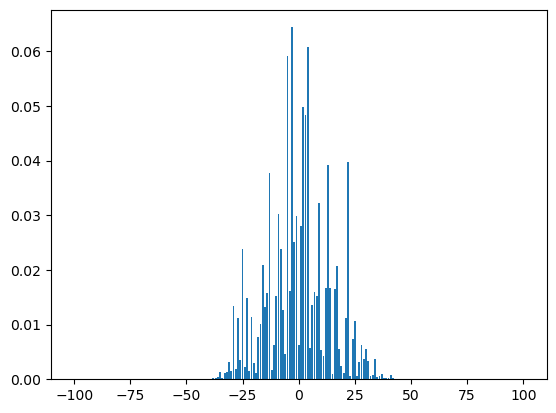

In [451]:
learned_mu_true = jax.nn.softmax(learned)
plt.bar(X, learned_mu_true)
plt.show()

In [415]:
# initialize a random array
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
theta = jax.random.normal(key=subkey, shape=X.shape)
X_reshaped = X.reshape(X.shape[0], 1).astype(float)

logit_loss(theta, mu_true, X_reshaped)
#learn_marginal_logits(mu_true)

#jax.grad(logit_loss)(theta, mu_true, X=X_reshaped)

#mu = gaussian_kernel(0, 1, X)
#X_reshaped = X.reshape(X.shape[0], 1).astype(float)
#jax.grad(ot_marginal_loss)(mu, mu_true, X_reshaped)
#jax.grad(loss)(jnp.array(0.1), mu_true, X)

Array(3285.7407, dtype=float32)

In [72]:
a = jnp.arange(4)
b = jnp.arange(5)
X, Y = jnp.meshgrid(a, b, indexing="ij")
XY = jnp.stack([X, Y], axis=-1).reshape((20, 2))
XY
#ot_marginal_loss

Array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3],
       [2, 4],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3],
       [3, 4]], dtype=int32)